# 2021-09-27 • Vary E/I proportion

Previously we just plotted STA's of inhibitory inputs. Now we measure the STA height, and compare it to the STA height of shuffled input spike trains.

Then we calculate separate true positive rates for inhibitory and excitatory connections, and we do this for a range of p_inhibitory.

## Prelude

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga` on **Wed 27 Oct** 2021, at 16:34 (UTC+0100).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/6765b0fd20b7c37cd4f0f9ff27aba199bac1dd61
) (Wed 27 Oct 2021, 16:27).
Uncommited changes to 3 files.

## Run simulation & connection tests

In [3]:
from voltage_to_wiring_sim.experiments.N_to_1_IE import Params, simulate_and_test_connections

In [4]:
v.pprint(Params())

Params
------
     sim_duration = 600
         timestep = 0.0001
       spike_rate = 20
           Δg_syn = 8E-10
            τ_syn = 0.007
    neuron_params = {'C': 1e-10, 'a': 30.0, 'b': -2e-09, 'c': -0.05, ...}
imaging_spike_SNR = 20
          v_syn_E = 0
          v_syn_I = -0.07
 num_spike_trains = 30
     p_inhibitory = 0.6
      p_connected = 0.6
  window_duration = 0.1
         rng_seed = None


In [5]:
from voltage_to_wiring_sim.conntest.classification_IE import (
    apply_threshold, evaluate_classification, sweep_threshold, calc_AUCs,
)

In [6]:
%%time

p_inh = np.linspace(0, 1, num=11, endpoint=True)

results = []

for p_i in p_inh:
    params = Params(p_inhibitory=p_i)
    r = simulate_and_test_connections(params)
    is_connected, is_inhibitory, test_summaries = r
    
    # Eval at fixed p_value threshold
    is_classified_as_connected = apply_threshold(test_summaries, p_value_threshold=0.05)
    evalu = evaluate_classification(is_classified_as_connected, is_connected, is_inhibitory)
    
    # Eval at all p_value thresholds
    thr_sweep = sweep_threshold(test_summaries, is_connected, is_inhibitory)
    AUC_inh, AUC_exc = calc_AUCs(thr_sweep)
    
    results.append((evalu.TPR_inh, evalu.TPR_exc, evalu.FPR, AUC_inh, AUC_exc))
    

TPR_inh, TPR_exc, FPR, AUC_inh, AUC_exc = zip(*results)

________________________________________________________________________________
[Memory] Calling voltage_to_wiring_sim.experiments.N_to_1_IE.simulate_and_test_connections...
simulate_and_test_connections(Params(sim_duration=600, timestep=0.0001, spike_rate=20.0, Δg_syn=8.000000000000001e-10, τ_syn=0.007, neuron_params=IzhikevichParams(C=1e-10, k=7e-07, v_r=-0.06, v_t=-0.04, v_peak=0.035, a=30.0, b=-2e-09, c=-0.05, d=1e-10), imaging_spike_SNR=20, v_syn_E=0.0, v_syn_I=-0.07, num_spike_trains=30, p_inhibitory=0.0, p_connected=0.6, window_duration=0.1, rng_seed=None))
..............................___________________________________simulate_and_test_connections - 19.7s, 0.3min
________________________________________________________________________________
[Memory] Calling voltage_to_wiring_sim.experiments.N_to_1_IE.simulate_and_test_connections...
simulate_and_test_connections(Params(sim_duration=600, timestep=0.0001, spike_rate=20.0, Δg_syn=8.000000000000001e-10, τ_syn=0.007, neuron_par

c:\users\tfiers\onedrive\phd\voltage-to-wiring-sim\codebase\voltage_to_wiring_sim\conntest\classification_IE.py:42: UserWarning: No connected inhibitory (pre,post)-pairs. TPR_inh is meaningless.
  warn("No connected inhibitory (pre,post)-pairs. TPR_inh is meaningless.")


..............................___________________________________simulate_and_test_connections - 17.4s, 0.3min
________________________________________________________________________________
[Memory] Calling voltage_to_wiring_sim.experiments.N_to_1_IE.simulate_and_test_connections...
simulate_and_test_connections(Params(sim_duration=600, timestep=0.0001, spike_rate=20.0, Δg_syn=8.000000000000001e-10, τ_syn=0.007, neuron_params=IzhikevichParams(C=1e-10, k=7e-07, v_r=-0.06, v_t=-0.04, v_peak=0.035, a=30.0, b=-2e-09, c=-0.05, d=1e-10), imaging_spike_SNR=20, v_syn_E=0.0, v_syn_I=-0.07, num_spike_trains=30, p_inhibitory=0.2, p_connected=0.6, window_duration=0.1, rng_seed=None))
..............................___________________________________simulate_and_test_connections - 17.7s, 0.3min
________________________________________________________________________________
[Memory] Calling voltage_to_wiring_sim.experiments.N_to_1_IE.simulate_and_test_connections...
simulate_and_test_connections(P

c:\users\tfiers\onedrive\phd\voltage-to-wiring-sim\codebase\voltage_to_wiring_sim\conntest\classification_IE.py:47: UserWarning: No connected excitatory (pre,post)-pairs. TPR_exc is meaningless.
  warn("No connected excitatory (pre,post)-pairs. TPR_exc is meaningless.")


..............................___________________________________simulate_and_test_connections - 21.5s, 0.4min


c:\users\tfiers\onedrive\phd\voltage-to-wiring-sim\codebase\voltage_to_wiring_sim\conntest\classification_IE.py:47: UserWarning: No connected excitatory (pre,post)-pairs. TPR_exc is meaningless.
  warn("No connected excitatory (pre,post)-pairs. TPR_exc is meaningless.")


^ This took ~19s per sim_and_test; times 11 so 3.5 minutes.

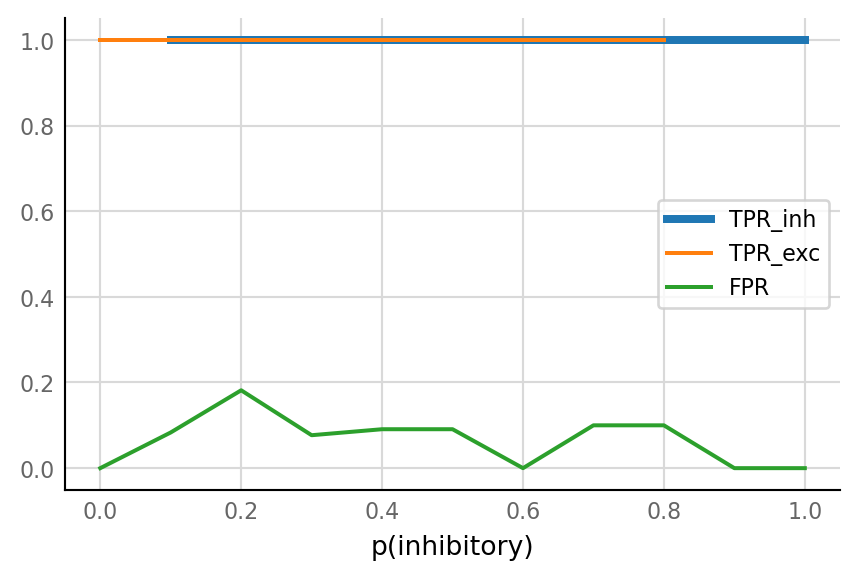

In [7]:
fig, ax = plt.subplots()

ax.plot(p_inh, TPR_inh, lw=3, label="TPR_inh")
ax.plot(p_inh, TPR_exc, label="TPR_exc")
ax.plot(p_inh, FPR, label="FPR")
ax.legend()
ax.set_xlabel("p(inhibitory)");

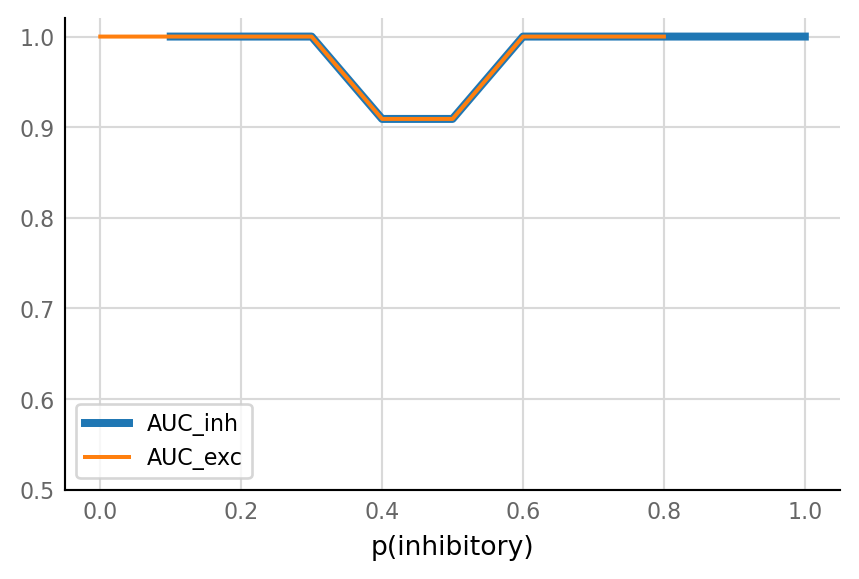

In [8]:
fig, ax = plt.subplots()

ax.plot(p_inh, AUC_inh, lw=3, label="AUC_inh")
ax.plot(p_inh, AUC_exc, label="AUC_exc")
ax.legend()
ax.set_ylim(0.5, 1.02)
ax.set_xlabel("p(inhibitory)");

## Reproducibility

In [15]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Mon 23 Aug** 2021, at 18:13 (UTC+0200).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/06aece7c804783047d4a1b6a4d84533bd7c8133d
) (Fri 20 Aug 2021, 21:41).

Uncommited changes to:
```
 M codebase/tests/test_run_embedded_tests.py
 M codebase/voltage_to_wiring_sim/N_to_1_experiment.py
 M codebase/voltage_to_wiring_sim/__init__.py
 M codebase/voltage_to_wiring_sim/sim/__init__.py
 M codebase/voltage_to_wiring_sim/sim/izhikevich_neuron.py
 M codebase/voltage_to_wiring_sim/sim/neuron_params.py
RM codebase/voltage_to_wiring_sim/sim/input_spike_trains.py -> codebase/voltage_to_wiring_sim/sim/poisson_spikes.py
 M codebase/voltage_to_wiring_sim/sim/synapses.py
 M notebooks/2021-07-30__inhibitory.ipynb
```

Platform:

Windows-10
CPython 3.8.6 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.5
matplotlib           3.3.4
numba                0.52.0
joblib               1.0.1
seaborn              0.11.1
scipy                1.6.0
preload              2.2
nptyping             1.4.0


Full conda list:

```
# packages in environment at C:\conda:
#
# Name                    Version                   Build  Channel
anyio                     2.0.2            py38haa244fe_4    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h294d835_2    conda-forge
async_generator           1.10                       py_0    conda-forge
atomicwrites              1.4.0              pyh9f0ad1d_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
babel                     2.9.0              pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
black                     20.8b1                     py_1    conda-forge
bleach                    3.3.0              pyh44b312d_0    conda-forge
bokeh                     2.2.3            py38haa244fe_0    conda-forge
brotlipy                  0.7.0           py38h294d835_1001    conda-forge
bzip2                     1.0.8                h8ffe710_4    conda-forge
ca-certificates           2020.12.5            h5b45459_0    conda-forge
certifi                   2020.12.5        py38haa244fe_1    conda-forge
cffi                      1.14.4           py38hd8c33c5_1    conda-forge
chardet                   4.0.0            py38haa244fe_1    conda-forge
click                     7.1.2              pyh9f0ad1d_0    conda-forge
cloudpickle               1.6.0                      py_0    conda-forge
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
conda                     4.9.2            py38haa244fe_0    conda-forge
conda-package-handling    1.7.2            py38h8934438_0    conda-forge
console_shortcut          0.1.1                         4  
cryptography              3.3.1            py38hd8c33c5_1    conda-forge
cycler                    0.10.0                     py_2    conda-forge
cytoolz                   0.11.0           py38h294d835_3    conda-forge
dask                      2021.1.0           pyhd8ed1ab_0    conda-forge
dask-core                 2021.1.0           pyhd8ed1ab_0    conda-forge
dataclasses               0.7                pyhb2cacf7_7    conda-forge
decorator                 4.4.2                      py_0    conda-forge
defusedxml                0.6.0                      py_0    conda-forge
distributed               2021.1.1         py38haa244fe_0    conda-forge
docutils                  0.16                     pypi_0    pypi
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
freetype                  2.10.4               h546665d_1    conda-forge
fsspec                    0.8.5              pyhd8ed1ab_0    conda-forge
gitdb                     4.0.5              pyhd8ed1ab_1    conda-forge
gitpython                 3.1.12             pyhd8ed1ab_0    conda-forge
heapdict                  1.0.1                      py_0    conda-forge
icu                       68.1                 h0e60522_0    conda-forge
idna                      2.10               pyh9f0ad1d_0    conda-forge
importlib-metadata        3.4.0            py38haa244fe_0    conda-forge
importlib_metadata        3.4.0                hd8ed1ab_0    conda-forge
iniconfig                 1.1.1              pyh9f0ad1d_0    conda-forge
intel-openmp              2020.3             h57928b3_311    conda-forge
ipykernel                 5.4.2            py38h7b7c402_0    conda-forge
ipython                   7.20.0           py38hc5df569_1    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
ipywidgets                7.6.3              pyhd3deb0d_0    conda-forge
jedi                      0.18.0           py38haa244fe_2    conda-forge
jinja2                    2.11.3             pyh44b312d_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
json5                     0.9.5              pyh9f0ad1d_0    conda-forge
jsonschema                3.2.0                      py_2    conda-forge
jupyter_client            6.1.11             pyhd8ed1ab_1    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1            py38h32f6830_1    conda-forge
jupyter_core              4.7.1            py38haa244fe_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py38haa244fe_1002    conda-forge
jupyter_latex_envs        1.4.6           py38h32f6830_1001    conda-forge
jupyter_nbextensions_configurator 0.4.1            py38haa244fe_2    conda-forge
jupyter_server            1.2.2            py38haa244fe_1    conda-forge
jupyterlab                3.0.5              pyhd8ed1ab_0    conda-forge
jupyterlab-classic        0.1.3              pyhd8ed1ab_0    conda-forge
jupyterlab-sublime        0.4.1                    pypi_0    pypi
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
jupyterlab_server         2.1.4              pyhd8ed1ab_0    conda-forge
jupyterlab_widgets        1.0.0              pyhd8ed1ab_1    conda-forge
jupytext                  1.10.0             pyh44b312d_0    conda-forge
jupytray                  0.7.post10+dirty           dev_0    <develop>
keyring                   21.8.0                   pypi_0    pypi
kiwisolver                1.3.1            py38hbd9d945_1    conda-forge
krb5                      1.17.2               hbae68bd_0    conda-forge
libarchive                3.5.1                h8686738_1    conda-forge
libblas                   3.9.0                     8_mkl    conda-forge
libcblas                  3.9.0                     8_mkl    conda-forge
libclang                  11.0.1          default_h5c34c98_1    conda-forge
libcurl                   7.71.1               h4b64cdc_8    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
liblapack                 3.9.0                     8_mkl    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libsolv                   0.7.17               h7755175_0    conda-forge
libssh2                   1.9.0                hb06d900_5    conda-forge
libtiff                   4.2.0                hc10be44_0    conda-forge
libxml2                   2.9.10               hf5bbc77_3    conda-forge
libxslt                   1.1.33               h65864e5_2    conda-forge
llvmlite                  0.35.0           py38h57a6900_1    conda-forge
locket                    0.2.0                      py_2    conda-forge
lxml                      4.6.2            py38h292cb97_1    conda-forge
lz4-c                     1.9.3                h8ffe710_0    conda-forge
lzo                       2.10              he774522_1000    conda-forge
m2w64-gcc-libgfortran     5.3.0                         6    conda-forge
m2w64-gcc-libs            5.3.0                         7    conda-forge
m2w64-gcc-libs-core       5.3.0                         7    conda-forge
m2w64-gmp                 6.1.0                         2    conda-forge
m2w64-libwinpthread-git   5.0.0.4634.697f757               2    conda-forge
mamba                     0.7.8            py38hdd88130_0    conda-forge
markdown-it-py            0.6.2              pyhd8ed1ab_0    conda-forge
markdown2                 2.4.0                    pypi_0    pypi
markupsafe                1.1.1            py38h294d835_3    conda-forge
matplotlib-base           3.3.4            py38h34ddff4_0    conda-forge
mdit-py-plugins           0.2.5              pyhd8ed1ab_0    conda-forge
menuinst                  1.4.16           py38he774522_1  
mistune                   0.8.4           py38h294d835_1003    conda-forge
mkl                       2020.4             hb70f87d_311    conda-forge
more-itertools            8.6.0              pyhd8ed1ab_0    conda-forge
mpmath                    1.1.0                      py_0    conda-forge
msgpack-python            1.0.2            py38hbd9d945_1    conda-forge
msys2-conda-epoch         20160418                      1    conda-forge
multipledispatch          0.6.0                    pypi_0    pypi
multitasking              0.0.9                    pypi_0    pypi
mypy_extensions           0.4.3            py38haa244fe_3    conda-forge
natsort                   7.1.1              pyhd8ed1ab_0    conda-forge
nb_conda_kernels          2.3.1            py38haa244fe_0    conda-forge
nbclassic                 0.2.6              pyhd8ed1ab_0    conda-forge
nbclient                  0.5.1                      py_0    conda-forge
nbconvert                 6.0.7            py38haa244fe_3    conda-forge
nbdime                    2.1.0                      py_0    conda-forge
nbformat                  5.0.8                      py_0    conda-forge
nest-asyncio              1.4.3              pyhd8ed1ab_0    conda-forge
notebook                  6.2.0            py38haa244fe_0    conda-forge
nptyping                  1.4.0                    pypi_0    pypi
numba                     0.52.0           py38h4c96930_0    conda-forge
numpy                     1.19.5           py38h0cc643e_1    conda-forge
oauthlib                  3.1.0                    pypi_0    pypi
oboe                      0.2                      pypi_0    pypi
olefile                   0.46               pyh9f0ad1d_1    conda-forge
openssl                   1.1.1i               h8ffe710_0    conda-forge
packaging                 20.8               pyhd3deb0d_0    conda-forge
pandas                    1.2.1            py38h4c96930_0    conda-forge
pandas-flavor             0.2.0                      py_0    conda-forge
pandoc                    2.11.4               h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.8.1              pyhd8ed1ab_0    conda-forge
partd                     1.1.0                      py_0    conda-forge
pathspec                  0.8.1              pyhd3deb0d_0    conda-forge
patsy                     0.5.1                      py_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.1.0            py38hf7ce48b_1    conda-forge
pip                       21.0.1             pyhd8ed1ab_0    conda-forge
pkginfo                   1.6.1                    pypi_0    pypi
pluggy                    0.13.1           py38haa244fe_4    conda-forge
powershell_shortcut       0.0.1                         3  
preload                   2.2                      pypi_0    pypi
prometheus_client         0.9.0              pyhd3deb0d_0    conda-forge
prompt-toolkit            3.0.14             pyha770c72_0    conda-forge
psutil                    5.8.0            py38h294d835_1    conda-forge
puprelease                1.8.1                     dev_0    <develop>
py                        1.10.0             pyhd3deb0d_0    conda-forge
pycosat                   0.6.3           py38h294d835_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.7.4              pyhd8ed1ab_0    conda-forge
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pypandoc                  1.6.3                    pypi_0    pypi
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py38haa244fe_7    conda-forge
pyqt-impl                 5.12.3           py38h885f38d_7    conda-forge
pyqt5-sip                 4.19.18          py38h885f38d_7    conda-forge
pyqtchart                 5.12             py38h885f38d_7    conda-forge
pyqtwebengine             5.12.1           py38h885f38d_7    conda-forge
pyrsistent                0.17.3           py38h294d835_2    conda-forge
pysocks                   1.7.1            py38haa244fe_3    conda-forge
pytest                    6.2.1            py38haa244fe_1    conda-forge
python                    3.8.6           h7840368_4_cpython    conda-forge
python-dateutil           2.8.1                      py_0    conda-forge
python_abi                3.8                      1_cp38    conda-forge
pytz                      2021.1             pyhd8ed1ab_0    conda-forge
pywin32                   300              py38h294d835_0    conda-forge
pywin32-ctypes            0.2.0                    pypi_0    pypi
pywinpty                  0.5.7            py38h32f6830_1    conda-forge
pyyaml                    5.4.1            py38h294d835_0    conda-forge
pyzmq                     22.0.1           py38h7a0e47e_0    conda-forge
qt                        5.12.9               h5909a2a_3    conda-forge
readme-renderer           28.0                     pypi_0    pypi
regex                     2020.11.13       py38h294d835_1    conda-forge
reproc                    14.2.1               h8ffe710_0    conda-forge
reproc-cpp                14.2.1               h0e60522_0    conda-forge
requests                  2.25.1             pyhd3deb0d_0    conda-forge
requests-oauthlib         1.3.0                    pypi_0    pypi
requests-toolbelt         0.9.1                    pypi_0    pypi
rfc3986                   1.4.0                    pypi_0    pypi
ruamel_yaml               0.15.80         py38h294d835_1004    conda-forge
scikit-learn              0.24.1           py38ha09990b_0    conda-forge
scipy                     1.6.0            py38h5f893b4_0    conda-forge
seaborn                   0.11.1               h57928b3_0    conda-forge
seaborn-base              0.11.1             pyhd8ed1ab_1    conda-forge
send2trash                1.5.0                      py_0    conda-forge
setuptools                49.6.0           py38haa244fe_3    conda-forge
setuptools-scm            5.0.1                    pypi_0    pypi
six                       1.15.0             pyh9f0ad1d_0    conda-forge
smmap                     3.0.5              pyh44b312d_0    conda-forge
snakeviz                  2.1.0              pyh9f0ad1d_0    conda-forge
sniffio                   1.2.0            py38haa244fe_1    conda-forge
sortedcontainers          2.3.0              pyhd8ed1ab_0    conda-forge
sqlite                    3.34.0               h8ffe710_0    conda-forge
statsmodels               0.12.2           py38h347fdf6_0    conda-forge
sympy                     1.7.1            py38haa244fe_1    conda-forge
tblib                     1.6.0                      py_0    conda-forge
terminado                 0.9.2            py38haa244fe_0    conda-forge
testpath                  0.4.4                      py_0    conda-forge
tfiers                    0.3.2                     dev_0    <develop>
threadpoolctl             2.1.0              pyh5ca1d4c_0    conda-forge
tk                        8.6.10               h8ffe710_1    conda-forge
toml                      0.10.2             pyhd8ed1ab_0    conda-forge
toolz                     0.11.1                     py_0    conda-forge
tornado                   6.1              py38h294d835_1    conda-forge
tqdm                      4.56.0             pyhd8ed1ab_0    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
tweepy                    3.10.0                   pypi_0    pypi
twine                     3.3.0                    pypi_0    pypi
typed-ast                 1.4.2            py38h294d835_0    conda-forge
typing_extensions         3.7.4.3                    py_0    conda-forge
typish                    1.9.1                    pypi_0    pypi
unitlib                   0.3                      pypi_0    pypi
unyt                      2.8.0                    pypi_0    pypi
urllib3                   1.26.3             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_2    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.28.29325          h5e1d092_0    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
widgetsnbextension        3.5.1            py38haa244fe_4    conda-forge
win_inet_pton             1.1.0            py38haa244fe_2    conda-forge
wincertstore              0.2             py38haa244fe_1006    conda-forge
windows-curses            2.2.0                    pypi_0    pypi
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
xarray                    0.16.2             pyhd8ed1ab_0    conda-forge
xlrd                      2.0.1              pyhd8ed1ab_3    conda-forge
xz                        5.2.5                h62dcd97_1    conda-forge
yaml                      0.2.5                he774522_0    conda-forge
yfinance                  0.1.55                   pypi_0    pypi
zeromq                    4.3.3                h0e60522_3    conda-forge
zict                      2.0.0                      py_0    conda-forge
zipp                      3.4.0                      py_0    conda-forge
zlib                      1.2.11            h62dcd97_1010    conda-forge
zstd                      1.4.8                h4e2f164_1    conda-forge
```